# Todo o relatório deste MVP consta anexado no diretório do Github.

## Camada Gold

Nesta camada “Gold” irei criar uma tabela a partir de Joins das tabelas fundamentais da camada “Silver”, sendo elas a tabela fato de pedidos, DimPagamentos, DimItens, DimProdutos, DimVendedores e DimClientes. A criação desta tabela flat tem como objetivo otimizar a performance de leitura e análise dos dados para este estudo, além de facilitar o seu consumo, permitindo assim responder de forma mais eficiente às perguntas definidas no início do projeto. Ainda assim, em caso de novas demandas analíticas, é possível recorrer à camada Silver, que mantém as tabelas organizadas em um modelo de esquema em floco de neve.

In [ ]:
%sql
CREATE DATABASE IF NOT EXISTS Gold;

In [ ]:
%sql SELECT * FROM Silver.fatopedidos_final limit 10;

order_id,customer_id,order_status,total_items,total_order_item_value,total_freight_value,total_order_value,order_purchase_timestamp_new,order_approved_at_new,order_delivered_carrier_date_new,order_delivered_customer_date_new,order_estimated_delivery_date_new
b513b10ef81dc22d15e850789a8a96b1,fa3c9c28979e812523cac4180cf5bbca,delivered,1,179.00,18.53,197.53,2018-02-25,2018-02-27,2018-02-27,2018-03-08,2018-03-21
2d58f989c5e9344556ea2a9526699249,1fc09040150013ea0ef014f02dcb4e97,delivered,1,89.99,16.39,106.38,2017-10-01,2017-10-01,2017-10-04,2017-10-10,2017-10-27
a92225110bfd8206a036f272ccf0fb1b,7f96cdc06aa0cfe77e71187d5035f22f,delivered,1,49.00,18.23,67.23,2018-05-03,2018-05-03,2018-05-04,2018-05-15,2018-06-04
d17a342bb9f94d40c3b6df4a600b5cee,511dfb4f5249ddae8cec62d7c650859c,delivered,2,59.98,14.78,74.76,2018-04-06,2018-04-06,2018-04-09,2018-04-10,2018-04-24
8dd9758206f8d9c23baf77b965e1c6dc,849d4f35271a07987c6af0c676c5ca31,delivered,1,84.99,15.35,100.34,2017-11-28,2017-11-28,2017-12-04,2017-12-19,2017-12-20
7c4281b08578a1e5e13e56814b3c6123,686ba249f6f98cc2610b58e5b9982e6a,delivered,1,157.00,18.00,175.00,2017-07-18,2017-07-18,2017-07-19,2017-07-24,2017-08-24
2b9c1a6934f2dd62cbe6df11189fb65f,82c5e6b98e498b4150818c913f3e9bc7,delivered,1,74.90,12.65,87.55,2018-02-10,2018-02-10,2018-02-21,2018-02-28,2018-03-14
0b93ff37e8344c6013bad16484c7fbe4,41b40faae6aeea7a8b6884948863386e,delivered,1,998.90,222.38,1221.28,2018-07-22,2018-07-23,2018-08-02,2018-08-07,2018-08-21
b311d7dd519074ae07f219467efbcc6c,958cac30fa94b05f7747e91ed8798ef8,delivered,1,79.90,9.47,89.37,2018-06-10,2018-06-10,2018-06-19,2018-06-20,2018-06-29
f9b9c3c69ef08b6eda32ed086133abb6,2ee87cede5826cd6458393028d3ec739,delivered,1,48.90,9.74,58.64,2018-02-14,2018-02-14,2018-02-16,2018-02-19,2018-03-01


Número de pedidos cancelados

In [ ]:
%sql
SELECT
    COUNT(*) AS total_cancelados
FROM
    Silver.fatopedidos_final
WHERE
    order_status = 'canceled';

total_cancelados
625


Taxa de cancelamento

In [ ]:
%sql
SELECT
    (COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) * 100.0) / COUNT(*) AS taxa_cancelamento
FROM
    Silver.fatopedidos_final;

taxa_cancelamento
0.62851338984926


Criando tabela com junção entre tabelas para a camada gold

In [ ]:
%sql
CREATE OR REPLACE TABLE Gold.dados_agregados
USING DELTA
AS
SELECT
    fp.order_id AS order_id,
    fp.customer_id AS customer_id,
    fp.order_status,
    fp.total_items,
    fp.total_order_item_value,
    fp.total_freight_value,
    fp.total_order_value,
    fp.order_purchase_timestamp_new,
    fp.order_approved_at_new,
    fp.order_delivered_carrier_date_new,
    fp.order_delivered_customer_date_new,
    fp.order_estimated_delivery_date_new,

    dt.payment_value,
    dt.payment_type,

    di.product_id,
    di.price,

    dp.product_category_name,

    dv.seller_id,
    dv.seller_city,

    dc.customer_unique_id

FROM
    Silver.fatopedidos_final fp
JOIN
    Silver.dimpagamentos_final dt ON fp.order_id = dt.order_id
JOIN
    Silver.dimitens_final di ON fp.order_id = di.order_id
JOIN
    Silver.DimProdutos dp ON di.product_id = dp.product_id
JOIN
    Silver.DimVendedores dv ON di.seller_id = dv.seller_id
JOIN
    Silver.DimClientes dc ON fp.customer_id = dc.customer_id;

num_affected_rows,num_inserted_rows


In [ ]:
%sql SELECT * FROM Gold.dados_agregados LIMIT 10;

order_id,customer_id,order_status,total_items,total_order_item_value,total_freight_value,total_order_value,order_purchase_timestamp_new,order_approved_at_new,order_delivered_carrier_date_new,order_delivered_customer_date_new,order_estimated_delivery_date_new,payment_value,payment_type,product_id,price,product_category_name,seller_id,seller_city,customer_unique_id
b513b10ef81dc22d15e850789a8a96b1,fa3c9c28979e812523cac4180cf5bbca,delivered,1,179.00,18.53,197.53,2018-02-25,2018-02-27,2018-02-27,2018-03-08,2018-03-21,197.53,boleto,f8b624d4e475bb8d1bddf1b65c6a64f6,179.00,utilidades_domesticas,b410bdd36d5db7a65dcd42b7ead933b8,goiania,8e45fca580e5130b6f912da95dcf3dd2
2d58f989c5e9344556ea2a9526699249,1fc09040150013ea0ef014f02dcb4e97,delivered,1,89.99,16.39,106.38,2017-10-01,2017-10-01,2017-10-04,2017-10-10,2017-10-27,106.38,credit_card,504f07e36481e5e72043def3d874b92a,89.99,esporte_lazer,2e1c9f22be269ef4643f826c9e650a52,sao paulo,d9d377accc816fe2dd7cea89daefdbc3
a92225110bfd8206a036f272ccf0fb1b,7f96cdc06aa0cfe77e71187d5035f22f,delivered,1,49.00,18.23,67.23,2018-05-03,2018-05-03,2018-05-04,2018-05-15,2018-06-04,67.23,credit_card,7f064525eaaa1ce9d22c085f7ff5413a,49.00,relogios_presentes,6560211a19b47992c3666cc44a7e94c0,sao paulo,2c1e1a424b3426cfb207bc61849b4203
d17a342bb9f94d40c3b6df4a600b5cee,511dfb4f5249ddae8cec62d7c650859c,delivered,2,59.98,14.78,74.76,2018-04-06,2018-04-06,2018-04-09,2018-04-10,2018-04-24,74.76,credit_card,5df6b48d02fedad4728b254cfcff3cc7,29.99,telefonia,b76dba6c951ab00dc4edf0a1aa88037e,sao paulo,9f7e43e32a3faca81cd43ee54af11543
d17a342bb9f94d40c3b6df4a600b5cee,511dfb4f5249ddae8cec62d7c650859c,delivered,2,59.98,14.78,74.76,2018-04-06,2018-04-06,2018-04-09,2018-04-10,2018-04-24,74.76,credit_card,5df6b48d02fedad4728b254cfcff3cc7,29.99,telefonia,b76dba6c951ab00dc4edf0a1aa88037e,sao paulo,9f7e43e32a3faca81cd43ee54af11543
8dd9758206f8d9c23baf77b965e1c6dc,849d4f35271a07987c6af0c676c5ca31,delivered,1,84.99,15.35,100.34,2017-11-28,2017-11-28,2017-12-04,2017-12-19,2017-12-20,17.71,credit_card,4c2394abfbac7ff59ec7a420918562fa,84.99,beleza_saude,cc419e0650a3c5ba77189a1882b7556a,santo andre,a4d4c09a2fe3081414f20b73ed30d9de
8dd9758206f8d9c23baf77b965e1c6dc,849d4f35271a07987c6af0c676c5ca31,delivered,1,84.99,15.35,100.34,2017-11-28,2017-11-28,2017-12-04,2017-12-19,2017-12-20,82.63,voucher,4c2394abfbac7ff59ec7a420918562fa,84.99,beleza_saude,cc419e0650a3c5ba77189a1882b7556a,santo andre,a4d4c09a2fe3081414f20b73ed30d9de
7c4281b08578a1e5e13e56814b3c6123,686ba249f6f98cc2610b58e5b9982e6a,delivered,1,157.00,18.00,175.00,2017-07-18,2017-07-18,2017-07-19,2017-07-24,2017-08-24,175.00,credit_card,3458b4c1fcbe46e2eedb48e00960a60e,157.00,cama_mesa_banho,cfb1a033743668a192316f3c6d1d2671,votorantim,70a8db6a5ae17c3a4e5df68bbeae451c
2b9c1a6934f2dd62cbe6df11189fb65f,82c5e6b98e498b4150818c913f3e9bc7,delivered,1,74.90,12.65,87.55,2018-02-10,2018-02-10,2018-02-21,2018-02-28,2018-03-14,87.55,credit_card,e53e557d5a159f5aa2c5e995dfdf244b,74.90,informatica_acessorios,88460e8ebdecbfecb5f9601833981930,maringa,0520a11c7af8a73b703f1d2e722c7c8a
0b93ff37e8344c6013bad16484c7fbe4,41b40faae6aeea7a8b6884948863386e,delivered,1,998.90,222.38,1221.28,2018-07-22,2018-07-23,2018-08-02,2018-08-07,2018-08-21,1221.28,credit_card,be7af429d53adfab190dacdaad6a1c9b,998.90,papelaria,b19f3ca2ea475913750f25a5c37c8d8f,divinopolis,8733d5194de65480195c9afdc3bf8881


Desempenho produtos - categorias que têm as maiores vendas em termos de unidades e valor

In [ ]:
%sql
SELECT
    product_category_name,
    SUM(total_items) AS total_units_sold,
    ROUND(SUM(payment_value), 2) AS total_sales_value
FROM
    Gold.dados_agregados
GROUP BY
    product_category_name
ORDER BY
    total_sales_value DESC
LIMIT 20;

product_category_name,total_units_sold,total_sales_value
cama_mesa_banho,17268,1712553.67
beleza_saude,12873,1657373.12
informatica_acessorios,12292,1585330.45
moveis_decoracao,15402,1430176.39
relogios_presentes,7418,1429216.68
esporte_lazer,11604,1392127.56
utilidades_domesticas,11677,1094758.13
automotivo,5714,852294.33
ferramentas_jardim,7682,838280.75
cool_stuff,4591,779698.00


Categorias que possuem o maior número de cancelamentos

In [ ]:
%sql
SELECT
    product_category_name,
    COUNT(*) AS cancellation_count
FROM
    Gold.dados_agregados
WHERE
    order_status = 'canceled'
GROUP BY
    product_category_name
ORDER BY
    cancellation_count DESC;

product_category_name,cancellation_count
utilidades_domesticas,59
esporte_lazer,52
informatica_acessorios,46
beleza_saude,40
moveis_decoracao,37
brinquedos,34
automotivo,30
relogios_presentes,21
bebes,20
ferramentas_jardim,20


Categorias que possuem a maior taxa de cancelamento

In [ ]:
%sql
SELECT
    product_category_name,
    COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) AS cancellation_count,
    COUNT(*) AS total_orders,
    ROUND((COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) * 100.0) / COUNT(*), 2) AS cancellation_rate
FROM
    Gold.dados_agregados
GROUP BY
    product_category_name
ORDER BY
    cancellation_rate DESC
    LIMIT 15;

product_category_name,cancellation_count,total_orders,cancellation_rate
pc_gamer,1,10,10.00
portateis_cozinha_e_preparadores_de_alimentos,1,15,6.67
dvds_blu_ray,3,71,4.23
fraldas_higiene,1,39,2.56
construcao_ferramentas_seguranca,5,199,2.51
construcao_ferramentas_jardim,4,245,1.63
instrumentos_musicais,11,718,1.53
telefonia_fixa,4,271,1.48
livros_interesse_geral,7,565,1.24
eletroportateis,8,701,1.14


Taxa de cancelamento por cidade

In [ ]:
%sql
SELECT
    seller_city,
    COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) AS num_cancellations,
    COUNT(*) AS num_orders,
    (COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) * 100.0) / COUNT(*) AS cancellation_rate
FROM
    Gold.dados_agregados
GROUP BY
    seller_city
ORDER BY
    num_cancellations DESC
    LIMIT 15;

seller_city,num_cancellations,num_orders,cancellation_rate
sao paulo,168,29157,0.57619096614878
santo andre,19,3095,0.61389337641357
campinas,16,1455,1.09965635738832
belo horizonte,16,2679,0.59723777528929
sorocaba,15,639,2.34741784037559
curitiba,14,3134,0.44671346522017
rio de janeiro,14,2529,0.55357848952155
guarulhos,13,2438,0.53322395406071
sao jose do rio preto,11,2682,0.41014168530947
sao jose dos campos,11,828,1.32850241545894


Tempo de entrega vs cancelamento - Tempo entre aprovação do pagamento e entrega ao cliente

In [ ]:
%sql
SELECT -- Análise do tempo de entrega e sua relação com o cancelamento de pedidos
    order_id,
    order_status,
    order_approved_at_new,
    order_delivered_customer_date_new,
    DATEDIFF(order_delivered_customer_date_new, order_approved_at_new) AS delivery_time_days,
    CASE
        WHEN order_status = 'canceled' THEN 1
        ELSE 0
    END AS is_cancelled
FROM
    Gold.dados_agregados
WHERE
    order_status = 'canceled'
    AND order_delivered_customer_date_new IS NOT NULL
    AND order_approved_at_new IS NOT NULL
ORDER BY
    delivery_time_days DESC;

order_id,order_status,order_approved_at_new,order_delivered_customer_date_new,delivery_time_days,is_cancelled
65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-04,2016-11-08,35,1
1950d777989f6a877539f53795b4c3c3,canceled,2018-02-19,2018-03-21,30,1
2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-10-10,2016-11-09,30,1
8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-09,2016-10-19,10,1
dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09,2016-10-16,7,1
770d331c84e5b214bd9dc70a10b829d0,canceled,2016-10-07,2016-10-14,7,1
dabf2b0e35b423f94618bf965fcb7514,canceled,2016-10-09,2016-10-16,7,1


Tempo de entrega ao transportador vs cancelamento - Tempo entre aprovação do pagamento e entrega ao transportador

In [ ]:
%sql
SELECT
    order_id,
    order_status,
    order_approved_at_new,
    order_delivered_carrier_date_new,
    DATEDIFF(order_delivered_carrier_date_new, order_approved_at_new) AS deliverytot_time_days,
    CASE
        WHEN order_status = 'canceled' THEN 1
        ELSE 0
    END AS is_cancelled
FROM
    Gold.dados_agregados
WHERE
    order_status = 'canceled'
    AND order_delivered_carrier_date_new IS NOT NULL
    AND order_approved_at_new IS NOT NULL
ORDER BY
    deliverytot_time_days DESC
    LIMIT 15;

order_id,order_status,order_approved_at_new,order_delivered_carrier_date_new,deliverytot_time_days,is_cancelled
1def7af24cb7182497acfd953f6dd88b,canceled,2017-12-23,2018-01-30,38,1
65d1e226dfaeb8cdc42f665422522d14,canceled,2016-10-04,2016-10-25,21,1
2c0032906c603dcc21cd954828fa77d0,canceled,2018-02-06,2018-02-16,10,1
47e96b5cb6f0592d336b6bf8a817d1c3,canceled,2018-01-22,2018-02-01,10,1
9ec3685b1f21c7dfff4f656392b186dd,canceled,2018-02-20,2018-02-27,7,1
854f8cb8dacdc3abc4cce7a7df6fcc1f,canceled,2018-02-02,2018-02-08,6,1
854f8cb8dacdc3abc4cce7a7df6fcc1f,canceled,2018-02-02,2018-02-08,6,1
fe9fae71b4fa7d05f1934adc54391f8d,canceled,2018-02-15,2018-02-21,6,1
4472eca3b65b1dca5e0d59c0e4e0c6bc,canceled,2018-02-10,2018-02-15,5,1
8beb59392e21af5eb9547ae1a9938d06,canceled,2016-10-09,2016-10-14,5,1


Tempo de entrega médio de pedidos cancelados versus não cancelados

In [ ]:
%sql
SELECT
    CASE
        WHEN order_status = 'canceled' THEN 'Cancelado'
        ELSE 'Não Cancelado'
    END AS pedido_status,
    AVG(DATEDIFF(order_delivered_customer_date_new, order_approved_at_new)) AS avg_delivery_time_days
FROM
    Gold.dados_agregados
WHERE
    order_delivered_customer_date_new IS NOT NULL
    AND order_approved_at_new IS NOT NULL
GROUP BY
    pedido_status;

pedido_status,avg_delivery_time_days
Não Cancelado,11.904914269815324
Cancelado,18.0


Tempo de entrega vs cancelamento - Comparação entre a data estimada de entrega e a data real de entrega

In [ ]:
%sql
SELECT
    order_id,
    order_status,
    order_estimated_delivery_date_new,
    order_delivered_customer_date_new,
    DATEDIFF(order_delivered_customer_date_new, order_estimated_delivery_date_new) AS delay_days
FROM
    Gold.dados_agregados
WHERE
    order_status = 'canceled'
ORDER BY
    delay_days DESC
LIMIT 15;

order_id,order_status,order_estimated_delivery_date_new,order_delivered_customer_date_new,delay_days
1950d777989f6a877539f53795b4c3c3,canceled,2018-03-09,2018-03-21,12
65d1e226dfaeb8cdc42f665422522d14,canceled,2016-11-25,2016-11-08,-17
2c45c33d2f9cb8ff8b1c86cc28c11c30,canceled,2016-12-08,2016-11-09,-29
8beb59392e21af5eb9547ae1a9938d06,canceled,2016-11-30,2016-10-19,-42
dabf2b0e35b423f94618bf965fcb7514,canceled,2016-11-30,2016-10-16,-45
dabf2b0e35b423f94618bf965fcb7514,canceled,2016-11-30,2016-10-16,-45
770d331c84e5b214bd9dc70a10b829d0,canceled,2016-11-29,2016-10-14,-46
fa6d0c0ef7a7849ab7847303d458df3c,canceled,2018-03-14,null,null
3a129877493c8189c59c60eb71d97c29,canceled,2018-02-23,null,null
7c0659561e8e95e839b8a4f9f4b6fab9,canceled,2018-06-04,null,null


Podemos verificar a partir da consulta acima que muitos pedidos que constam como cancelados, não chegaram a ser entregues aos clientes, resultando na lógica de que o cancelamento não foi realizado por insatisfação pelo produto, mas sim outros fatores.

Faixa de preço do produto x taxa de cancelamento

In [ ]:
%sql
SELECT
    CASE
        WHEN price <= 50 THEN '0-50'
        WHEN price > 50 AND price <= 100 THEN '51-100'
        WHEN price > 100 AND price <= 200 THEN '101-200'
        WHEN price > 200 THEN '201+'
        ELSE 'Sem Preço'
    END AS price_range,
    COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) AS cancellation_count,
    COUNT(*) AS total_orders,
    ROUND((COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) * 100.0) / COUNT(*), 2) AS cancellation_rate_c
FROM
    Gold.dados_agregados
GROUP BY
    price_range
ORDER BY
    cancellation_rate_c DESC;

price_range,cancellation_count,total_orders,cancellation_rate_c
201+,116,14002,0.83
0-50,187,41079,0.46
101-200,120,27923,0.43
51-100,143,34597,0.41


Tipo de pagamento x taxa de cancelamento de pedidos

In [ ]:
%sql
SELECT
    payment_type,
    COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) AS cancellation_count,
    COUNT(*) AS total_orders,
    ROUND((COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) * 100.0) / COUNT(*), 2) AS cancellation_rate_pay
FROM
    Gold.dados_agregados
GROUP BY
    payment_type
ORDER BY
    cancellation_rate_pay DESC;

payment_type,cancellation_count,total_orders,cancellation_rate_pay
credit_card,435,86769,0.50
voucher,29,6274,0.46
boleto,96,22867,0.42
debit_card,6,1691,0.35


Cancelamentos x descontos

In [ ]:
%sql
WITH cancelamentos_com_desconto AS (
    SELECT
        customer_unique_id,
        order_id,
        payment_value,
        total_order_value,
        (total_order_value - payment_value) AS desconto,
        order_status
    FROM
        Gold.dados_agregados
    WHERE
        total_order_value > 0
        AND order_status = 'canceled'
        AND (total_order_value - payment_value) > 0
)

SELECT
    customer_unique_id,
    order_id,
    desconto,
    ROUND((desconto * 100.0) / total_order_value, 2) AS percentual_desconto
FROM
    cancelamentos_com_desconto
ORDER BY
    percentual_desconto DESC
LIMIT 15;

customer_unique_id,order_id,desconto,percentual_desconto
2592816433dfbb3051af91ba91625de5,1057bf6391c17f9b6960dd996029e1dc,166.34,99.80
2592816433dfbb3051af91ba91625de5,1057bf6391c17f9b6960dd996029e1dc,157.21,94.32
15d1c313b6721f3ecc985a3832c6b757,2b020fc22c27548cc22ee8447edad356,100.00,93.37
c5877771ec620bea58cd167a3ddc1adc,ec07c952b2e699cd885db38a3c9362f9,102.39,93.33
8964628f0dd7ab0fe0751abedcbd317d,847e04c1fabd29748790e74c1430c603,45.34,92.32
2592816433dfbb3051af91ba91625de5,1057bf6391c17f9b6960dd996029e1dc,151.71,91.02
60b2ec19b8c18082cdb5180106a97cb5,83e6338b5cf25dcf222551cb8da8d0d6,2442.82,90.72
2592816433dfbb3051af91ba91625de5,1057bf6391c17f9b6960dd996029e1dc,150.52,90.31
2592816433dfbb3051af91ba91625de5,1057bf6391c17f9b6960dd996029e1dc,148.55,89.13
daba2e7a00c149161c68cbb18db656a9,854f8cb8dacdc3abc4cce7a7df6fcc1f,59.24,87.76


Taxa de cancelamento de pedidos por cliente

In [ ]:
%sql
WITH cancelamentos_cliente AS (
    SELECT
        customer_unique_id,
        COUNT(*) AS total_orders,
        COUNT(CASE WHEN order_status = 'canceled' THEN 1 END) AS canceled_orders
    FROM
        Gold.dados_agregados
    GROUP BY
        customer_unique_id
)

SELECT
    customer_unique_id,
    total_orders,
    canceled_orders,
    ROUND((canceled_orders * 100.0) / total_orders, 2) AS cancellation_rate
FROM
    cancelamentos_cliente
WHERE
    canceled_orders > 0
ORDER BY
    cancellation_rate DESC
LIMIT 15;

customer_unique_id,total_orders,canceled_orders,cancellation_rate
22af178809fa6887af2cc4f7d7bdc0bc,6,6,100.00
a28a87da2cbdedcaeef1958a821308ad,1,1,100.00
76e697cd6a76cf072e9307fa9f4a6026,1,1,100.00
b2bb87ebda9c0aad99e72716de580b63,1,1,100.00
8baf40106768ade624db23a1fd11808e,1,1,100.00
c1242a4d8e2d5dde133a8c46d5b22975,1,1,100.00
786abe8655280c105e08af1030cd3738,1,1,100.00
8cfb20eff1ce8185a15ab1df1a8969e3,1,1,100.00
25c00b3bb56030f1ac1f254da33f3b0c,1,1,100.00
10246c1deb72f0dac263516219a06bd4,1,1,100.00


In [ ]:
%sql
CREATE OR REPLACE TEMP VIEW tabela_com_descontos AS
SELECT
    order_id,
    payment_value,
    total_order_value,
    (total_order_value - payment_value) AS desconto,
    order_status
FROM
    Gold.dados_agregados;

In [ ]:
%sql
SELECT * FROM tabela_com_descontos WHERE order_status = 'canceled'
ORDER BY desconto DESC
LIMIT 15;

order_id,payment_value,total_order_value,desconto,order_status
83e6338b5cf25dcf222551cb8da8d0d6,250.00,2692.82,2442.82,canceled
c08dd05931abd8cb08aad3d31e39bfed,203.07,1423.52,1220.45,canceled
83e6338b5cf25dcf222551cb8da8d0d6,2442.82,2692.82,250.00,canceled
eb0393138e2e8b7164947608489f069e,100.00,325.86,225.86,canceled
c08dd05931abd8cb08aad3d31e39bfed,1220.45,1423.52,203.07,canceled
1057bf6391c17f9b6960dd996029e1dc,0.33,166.67,166.34,canceled
1057bf6391c17f9b6960dd996029e1dc,9.46,166.67,157.21,canceled
1057bf6391c17f9b6960dd996029e1dc,14.96,166.67,151.71,canceled
1057bf6391c17f9b6960dd996029e1dc,16.15,166.67,150.52,canceled
1057bf6391c17f9b6960dd996029e1dc,18.12,166.67,148.55,canceled


Carregando tabela de descontos em um Pandas Dataframe

In [ ]:
df_pandas = spark.table("tabela_com_descontos").toPandas()

df_pandas.head()

/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [payment_value, total_order_value, desconto] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


,order_id,payment_value,total_order_value,desconto,order_status
0,bec5a824282dde8cdfe6aaf6b6525a6c,62.01,62.01,0.00,delivered
1,675b1c40d6b0d4397714c1087eeafb01,22.51,22.51,0.00,delivered
2,927ace45edbc6f486fa5656683aa791d,106.54,106.54,0.00,delivered
3,0baa56401ae212e308d73cba2911ae20,87.22,87.22,0.00,delivered
4,0baa56401ae212e308d73cba2911ae20,87.22,87.22,0.00,delivered


Filtrando dataframe

In [ ]:
df_filtered = df_pandas[df_pandas['order_status'].isin(['delivered', 'canceled'])]

Visualizando a distribuição dos descontos para pedidos cancelados x entregues

<command-13254518166462>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['point_size'] = df_filtered['order_status'].apply(lambda x: 10 if x == 'canceled' else 3)


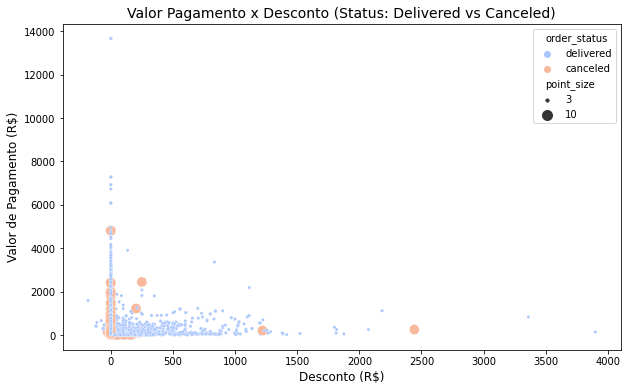

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


df_filtered['point_size'] = df_filtered['order_status'].apply(lambda x: 10 if x == 'canceled' else 3)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='desconto', y='payment_value', data=df_filtered, hue='order_status', palette='coolwarm', size='point_size', sizes=(10, 100))


plt.title('Valor Pagamento x Desconto (Status: Delivered vs Canceled)', fontsize=14)
plt.xlabel('Desconto (R$)', fontsize=12)
plt.ylabel('Valor de Pagamento (R$)', fontsize=12)


plt.show()

Foi verificado se os cancelamentos podem estar ligados a compras com descontos concedidos. Porém, a grande maioria dos pedidos cancelados não obteve descontos, podendo ser um incentivo para o cliente retornar a finalizar alguma outra compra, e até mesmo um motivador para futuros clientes, principalmente para aqueles que desejam comprar produtos com valores mais altos.